<a href="https://colab.research.google.com/github/2SEHI/K-Digital_Lecture/blob/main/0806_keras(OpenCV_ML)/OpenCV_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OpenCV와 머신러닝
- OpenCV와 연계해서 머신러닝을 하는 방법은 2가지가 있는데 하나는 OpenCV를 이용해서 이미지를 전처리하고 머신러닝 알고리즘을 별도로 적용하는 것이며 다른 하나는 OpenCV에 내장된 머신러닝 모듈을 이용하는 방식입니다.
- 최근의 OpenCV라이브러리에는 머신러닝 모듈이 탑재되었습니다.

## 1.OpenCV ML
- Boosting, EM, KNN, NormalBayesClassifier, LogisticRegression, RTrees, SimulatedAnnealing, SolverSystem, SVM, SVMSGD, ANN_MLP 등의 모듈이 제공됨
- 머신러닝을 공부할때는 앙상블을 기억해두어야 하는데 여러가지 알고리즘을 적용하는 방식입니다.
- cv2.ml이라는 패키지에 존재하고 create()함수를 이용해서 객체를 생성합니다. 
- 최근의 머신 러닝에서는 하나의 알고리즘만 사용하는 경우가 드물고 이전에 존재하던 알고리즘들로 새로운 모델을 만들어서 배포하는 경우가 많기 때문에 대부분의 경우는 학습된 모델을 읽어서 순방향 계산의 추론 단계만 수행하여 사용할 수 있는 형태로 가고 있습니다.

- gzip모듈 : 압축된 파일들을 풀어서 사용할 수 있도록 해주는 파이썬 기본 모듈
- 2층 신경망 랜덤 샘플링 미니 배치(Batch - 일괄로 번역, 모아서 처리한다는 의미) 개수가 너무 적으면 안됩니다.


- 가장 기본적인 신경망을 만드는 방법

In [ ]:
#1
def extract_data(filename, num_images):
  '''Extract the images into a 4D tensor [image index, y, x, channels].
     Values are rescaled from [0, 255] down to [0, 1].
  '''
##  print('Extracting', filename)
  with gzip.open(filename) as bytestream:
    bytestream.read(16)
    buf = bytestream.read(IMAGE_SIZE * IMAGE_SIZE * num_images)
    data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
##    data = data/PIXEL_DEPTH
    data = data.reshape(num_images, IMAGE_SIZE, IMAGE_SIZE)
    return data

def extract_labels(filename, num_images):
  '''Extract the labels into a vector of int64 label IDs.'''
##  print('Extracting', filename)
  with gzip.open(filename) as bytestream:
    bytestream.read(8)
    buf = bytestream.read(1 * num_images)
    labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int32)
  return labels
def ont_hot_encoding(y): # assume that y is 1-D array
    t = np.zeros((y.size, 10), dtype=np.float32)
    for i, row in enumerate(t):
        row[y[i]] = 1      
    return t
  
# Extract it into np arrays.
def load_MINIST(flatten=True, one_hot=True):
  x_train=extract_data('./data/train-images-idx3-ubyte.gz',  60000)
  y_train=extract_labels('./data/train-labels-idx1-ubyte.gz',60000)
  x_test =extract_data('./data/t10k-images-idx3-ubyte.gz',   10000)
  y_test =extract_labels('./data/t10k-labels-idx1-ubyte.gz', 10000)

  if flatten:
    x_train= x_train.reshape(-1, IMAGE_SIZE*IMAGE_SIZE) # (60000, 784)
    x_test = x_test.reshape(-1, IMAGE_SIZE*IMAGE_SIZE)  # (10000, 784)
  if one_hot:
    y_train = ont_hot_encoding(y_train)
    y_test = ont_hot_encoding(y_test)    
  return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_MINIST()

#2 – 인공 신경망 생성
# Sequential로 입력을 생성하던 부분에 해당합니다
Ann = cv2.ml.ANN_MLP_create()
# 입력 부분
ann.setLayerSizes(np.array([784, 100, 10]))
ann.setTrainMethod(cv2.ml.ANN_MLP_BACKPROP)
ann.setActivationFunction(cv2.ml.ANN_MLP_SIGMOID_SYM)
ann.setTermCriteria((cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_COUNT,1,1e-5))

trainData = cv2.ml.TrainData_create(samples=x_train,
                                    layout=cv2.ml.ROW_SAMPLE,
                                    responses=y_train)
ret = ann.train(trainData)

#3
train_loss_list     = []
train_accuracy_list = []
test_loss_list      = []
test_accuracy_list  = []

batch_size = 1000
train_size = 60000

# 반복 횟수
iters_num  = 10000
iter_per_epoch = train_size//batch_size

for i in range(iters_num):
#3-1
  batch_mask = np.random.choice(train_size, batch_size)
  x_batch = x_train[batch_mask]
  y_batch = y_train[batch_mask]
  
  trainData = cv2.ml.TrainData_create(samples=x_batch,
                                      layout=cv2.ml.ROW_SAMPLE,
                                      responses=y_batch)    
  ret = ann.train(trainData, flags=cv2.ml.ANN_MLP_UPDATE_WEIGHTS)

#3-2
  if i % iter_per_epoch == 0:    
    y_target = np.argmax(y_train, axis=1)
    ret, res_train = ann.predict(x_train)
    y_predict = np.argmax(res_train, axis = 1)
    train_accuracy = np.sum(y_target==y_predict)/len(y_target)
    train_loss = np.sum((y_train-res_train)**2)
    train_loss /= x_train.shape[0] # 60000
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(train_loss)

    y_target = np.argmax(y_test, axis=1)
    ret, res_test = ann.predict(x_test)
    y_predict = np.argmax(res_test, axis = 1)
    test_accuracy = np.sum(y_target==y_predict)/len(y_target)
    test_loss = np.sum((y_test-res_test)**2)
    test_loss /= x_test.shape[0] # 10000
    test_accuracy_list.append(test_accuracy)
    test_loss_list.append(test_loss)
    
    print('train_accuracy[{}]={}, '.format(i, train_accuracy), end='')
    print('train_loss={}'.format(train_loss))

    #4
ann.save('./data/ann-minist_2layer_BP.train')

x = list(range(len(train_loss_list)))
plt.plot(x, train_loss_list, label='train_loss')
plt.plot(x, test_loss_list, label='test_loss')

plt.legend(loc='best')
plt.show()

plt.plot(x, train_accuracy_list, label='train_accuracy')
plt.plot(x, test_accuracy_list, label='test_accuracy')
plt.legend(loc='best')
plt.show()


### 미님배치를 사용하지 않고 50번 훈련 - 시간이 오래걸림
- 제약을 제거하고 미니배치가 없습니다.

In [ ]:
''' ref1: http://yann.lecun.com/exdb/mnist/
    ref2: https://gist.github.com/ischlag/41d15424e7989b936c1609b53edd1390
'''
import gzip
import cv2
import numpy as np
import matplotlib.pyplot as plt

IMAGE_SIZE  = 28
PIXEL_DEPTH = 255
NUM_LABELS  = 10
#1
def extract_data(filename, num_images):
  '''Extract the images into a 4D tensor [image index, y, x, channels].
     Values are rescaled from [0, 255] down to [0, 1].
  '''
##  print('Extracting', filename)
  with gzip.open(filename) as bytestream:
    bytestream.read(16)
    buf = bytestream.read(IMAGE_SIZE * IMAGE_SIZE * num_images)
    data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
##    data = data/PIXEL_DEPTH
    data = data.reshape(num_images, IMAGE_SIZE, IMAGE_SIZE)
    return data

def extract_labels(filename, num_images):
  '''Extract the labels into a vector of int64 label IDs.'''
##  print('Extracting', filename)
  with gzip.open(filename) as bytestream:
    bytestream.read(8)
    buf = bytestream.read(1 * num_images)
    labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int32)
  return labels
def ont_hot_encoding(y): # assume that y is 1-D array
    t = np.zeros((y.size, 10), dtype=np.float32)
    for i, row in enumerate(t):
        row[y[i]] = 1      
    return t
  
# Extract it into np arrays.
def load_MINIST(flatten=True, one_hot=True):
  x_train=extract_data('./data/train-images-idx3-ubyte.gz',60000)
  y_train=extract_labels('./data/train-labels-idx1-ubyte.gz',60000)
  x_test=extract_data('./data/t10k-images-idx3-ubyte.gz',10000)
  y_test=extract_labels('./data/t10k-labels-idx1-ubyte.gz',10000)

  if flatten:
    x_train= x_train.reshape(-1, IMAGE_SIZE*IMAGE_SIZE) # (60000, 784)
    x_test = x_test.reshape(-1, IMAGE_SIZE*IMAGE_SIZE)  # (10000, 784)
  if one_hot:
    y_train = ont_hot_encoding(y_train)
    y_test = ont_hot_encoding(y_test)    
  return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_MINIST()

#2
ann = cv2.ml.ANN_MLP_create()
ann.setLayerSizes(np.array([784, 100, 10]))
##ann.setLayerSizes(np.array([784, 50, 50, 10]))

# 제약을 제거하고 미니배치가 없습니다.
##ann.setTrainMethod(cv2.ml.ANN_MLP_RPROP)
ann.setActivationFunction(cv2.ml.ANN_MLP_SIGMOID_SYM)
ann.setTermCriteria((cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_COUNT,20,1e-5))

trainData = cv2.ml.TrainData_create(samples=x_train,
                                    layout=cv2.ml.ROW_SAMPLE,
                                    responses=y_train)
ret = ann.train(trainData)

#3
train_loss_list     = []
train_accuracy_list = []
test_loss_list      = []
test_accuracy_list  = []

train_size = 60000
iters_num  = 100

for i in range(iters_num):
  ret = ann.train(trainData, flags=cv2.ml.ANN_MLP_UPDATE_WEIGHTS)

  y_target = np.argmax(y_train, axis=1)
  ret, res_train = ann.predict(x_train)
  y_predict = np.argmax(res_train, axis = 1)
  train_accuracy = np.sum(y_target==y_predict)/len(y_target)
  train_loss = np.sum((y_train-res_train)**2)
  train_loss /= x_train.shape[0] # 60000
  train_accuracy_list.append(train_accuracy)
  train_loss_list.append(train_loss)

y_target = np.argmax(y_test, axis=1)
  ret, res_test = ann.predict(x_test)
  y_predict = np.argmax(res_test, axis = 1)
  test_accuracy = np.sum(y_target==y_predict)/len(y_target)
  test_loss = np.sum((y_test-res_test)**2)
  test_loss /= x_test.shape[0] # 10000
  test_accuracy_list.append(test_accuracy)
  test_loss_list.append(test_loss)
    
  print('train_accuracy[{}]={}, '.format(i, train_accuracy), end='')
  print('test_accuracy={}'.format(test_accuracy))
  
print('train_loss={}, '.format(train_loss), end='')
print('test_loss={}'.format(test_loss))
  

#4
ann.save('./data/ann-minist_2layer_100RPROP.train')
##ann.save('./data/ann-minist_3layer_50RPROP.train')

x = list(range(len(train_loss_list)))
plt.plot(x, train_loss_list, label='train_loss')
plt.plot(x, test_loss_list, label='test_loss')

plt.legend(loc='best')
plt.show()

plt.plot(x, train_accuracy_list, label='train_accuracy')
plt.plot(x, test_accuracy_list, label='test_accuracy')
plt.legend(loc='best')
plt.show()


# 이벤트 전처리 
- 프로그래밍을 할 때 이벤트 전처리를 해야할 일이 생기면 이벤트를 처리하는 것이 객체인지 함수가 처리하는 것인지 확인을 잘 해야 합니다. 객체가 처리하는 경우는 대부분 메소드 이름과 모양이 결정되어 있습니다. 오버라이딩으로 처리합니다. 함수가 처리하는 경우는 이름은 자유롭게 만들 수 있지만 매개변수는 룰을 지켜야 하고 대부분 부가 정보를 넘겨주는 방법을 제공합니다. 파이썬에서 이 부가 정보의 자료형은 특별한 경우가 아니면 dict입니다.

- 이벤트를 처리해야 하는 객체에 앞에서 만든 객체나 함수를 이벤트와 연결하면 됩니다.마우스 조정은 좌표가 중요
- 마우스 이벤트 : 함수이름(이벤트 객체, x좌표, y좌표, 플래그, 부가정보)로 마우스 이벤트 처리
    - 이벤트 객체는 누구에거 어떤 이벤트가 발생했는지에 대한 정보를 전달합니다
    - 플래그는 같이 누른 조합키에 대한 정보가 전달 됩니다.

# 실습
- 앞의 훈련 모델을 파일로 가지고와서 마우스로 숫자를 그리면 판별할 수 있습니다.

In [ ]:
import cv2
import numpy as np

#1
ann = cv2.ml_ANN_MLP.load('../data/ann-minist_2layer_BP.train')

#2
def onMouse(event, x, y, flags, param):
    if event == cv2.EVENT_MOUSEMOVE:
        if flags & cv2.EVENT_FLAG_LBUTTON:
            cv2.circle(dst, (x, y), 10, (255, 255, 255), -1)
    cv2.imshow('dst', dst)
    
dst  = np.zeros(shape=(512, 512, 3), dtype=np.uint8)
cv2.imshow('dst',dst)
cv2.setMouseCallback('dst', onMouse)
    
mode   = cv2.RETR_EXTERNAL
method = cv2.CHAIN_APPROX_SIMPLE
font = cv2.FONT_HERSHEY_SIMPLEX  
x_img = np.zeros(shape=(28, 28), dtype=np.uint8)

#3
while True:
    key = cv2.waitKey(25)    
    if key == 27: 
        break;
    elif key == ord('r'):
        dst[:,:] = 0
        cv2.imshow('dst',dst)
    elif key == ord(' '):
        gray = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
        contours, _ = cv2.findContours(gray, mode, method)
        for i, cnt in enumerate(contours):
#3-1
            x, y, width, height = cv2.boundingRect(cnt)
            cv2.rectangle(dst, (x, y), (x+width, y+height), (0,0,255), 2)
            cx, cy = x + width/2, y + height/2
            if width > height:
                r = width/2
            else:
                r = height/2            
##            (cx,cy),r = cv2.minEnclosingCircle(cnt)
            cx, cy, r= int(cx), int(cy), int(r)
            img = gray[cy-r:cy+r, cx-r:cx+r]
            img = cv2.resize(img, dsize=(20, 20),interpolation=cv2.INTER_AREA)            
            x_img[:,:] = 0
            x_img[4:24, 4:24] = img
            x_img = cv2.dilate(x_img, None, 2)
            x_img = cv2.erode(x_img, None, 4)
            cv2.imshow('x_img', x_img)
#3-2
            x_test = np.float32(x_img.flatten())
            _, res = ann.predict(x_test.reshape(-1, 784))
##            print('res=', res)
            y_predict = np.argmax(res, axis = 1)
            print('y_predict=', y_predict)
            digit = int(y_predict[0])
            cv2.putText(dst, str(digit), (x, y), font, 3, (255,0,0), 5)
        
        cv2.imshow('dst',dst)
cv2.destroyAllWindows()


y_predict= [0]
y_predict= [1]


- 마우스로 입력한 숫자의 두께와 종횡비 등이 글자 인식에 영향을 미치므로 모멘트나 HOG등의 특징을 사용하여 인식기를 구현하거나 후처리를 통해 인식률을 높일 수 있고 DNN(심층 신경망 - 층을 여러개 쌓음)이나 CNN을 이용하면 인식률은 더 높아집니다


## Average Hash를 이용한 유사 이미지 검출
1) Average Hash
- 이미지를 비교 가능한 해시 값으로 나타낸 것
- MD5, SHA256 같은 암호화 알고리즘을 이요해서 데이터 값을 간단한 해시 값으로 변환할 수 있습니다.
- 패스워드는 암호화한 뒤 원본으로 복호화가 불가능하게 만들어야 합니다.
- 반면, 이미지 처리에서는 이런 알고리즘을 직접 사용하지는 않는데 이미지는 대부분 압축이 되어 있고 포맷에 따라 형식이 다르기 때문입니다.
- 일반적인 알고리즘 대신에 사용할 수 있는 방식 중의 하나가 Average Hash입니다.
- 이미지를  8 X 8로 축소
- 색을 흑백으로 변환
- 이미지의 각 픽셀의 평균을 계산합니다.
- 각 픽셀의 어두운 정도가 평균보다 크면 1, 평균보다 작으면 0으로 입력합니다. 이를 통해 이미지 명암을 해결할 수 있습니다.

2) Pillow 패키지
- OpenCV처럼 이미지를 다루기 위한 패키지

3) 샘플 이미지 가져오기
- 캘리포니아 공과 대학에서 제공하는 이미지 - 많이 사용
 - http://www.vision.caltech.edu/Image_Datasets/Caltech101/#Download 에서 다운로드


### 기본 설정

In [ ]:
from PIL import Image
import numpy as np
import os, re

# 이미지 파일 디렉토리 설정
search_dir = '../data/101_ObjectCategories'
# 이미지 캐싱 디렉토리
cache_dir = '../data/101_ObjectCategories/cache_avhash'

if not os.path.exists(cache_dir):
    os.mkdir(cache_dir)

In [ ]:
def average_hash(fname, size=16):
    fname2 = fname[len(search_dir):]

    cache_file = cache_dir + '/' + fname2.replace('\\', '_') + '.csv'
    if '/' in fname2:
        cache_file = cache_dir + '/' + fname2.replace('/', '_') + '.csv'  
   
    if not os.path.exists(cache_file):
        # 이미지 열기
        img = Image.open(fname)
#         print(img)
        img = img.convert('L').resize((size, size), Image.ANTIALIAS)
        # numpy 자료형으로 변경
        pixels = np.array(img.getdata()).reshape((size, size))
        # 평균
        avg = pixels.mean()
        # 평균보다 크면 1, 그렇지 않으면 0
        px = 1 * (pixels > avg)
        np.savetxt(cache_file, px, fmt='%.0f', delimiter=',')
    else :
        px = np.loadtxt(cache_file, delimiter=',')
    return px

# 해밍 거리 (Hamming Distance)를 계산해주는 함수
- 해밍 거리는 유사도 분석을 위해서 거리를 측정하거나 에러 검출을 위한 코드
- 해밍 거리는 에러 검출만 가능한게 아니라 수정도 가능합니다.


In [ ]:
def hamming_dist(a, b):
    aa = a.reshape(1, -1)
    ab = b.reshape(1, -1)
    
    dist = (aa != ab).sum()
    return dist


a_list = np.array(['A','b','C'])
b_list = np.array(['c','q','C'])
hamming_dist(a_list, b_list)

2

## 모든 디렉토리에 처리를 적용하는 함수

In [ ]:
def enum_all_files(path):
    for root, dirs, files in os.walk(path):
        for f in files:
            fname = os.path.join(root, f)
            if re.search(r'\.(jpg|jpeg|png)$', fname):
                yield fname

### 유사 이미지 검출해주는 함수

In [ ]:
def find_image(fname, rate):
    
    src = average_hash(fname)
    for fname in enum_all_files(search_dir) :
        dst = average_hash(fname)
        diff_r = hamming_dist(src, dst) / 256
        if diff_r < rate :
            yield(diff_r, fname)

### 유사 이미지 검출


In [ ]:
srcfile = search_dir + '/camera/image_0001.jpg'

html = ""

sim = list(find_image(srcfile, 0.25))

sim = sorted(sim, key=lambda x:x[0])
for r, f in sim :
    print(r, ">", f)
    s = '<div style="float:left;"> <h3>[차이:]' + str(r) + '-' + os.path.basename(f) + ']</h3>' + '<p><a href=""' + f + '"><img src="' + f + '"width=400>"' + '</a></p></div>'
    html += s
html = """
<html>
<head><meta charset="utf-8"></head>
<body><h3>원래 이미지</h3>
<p><img src='{0} width=400'></p>{1}
</body>
</html>
""".format(srcfile, html)

with open("./avhash-sear-output.html", "w", encoding="utf-8") as f :
    f.write(html)
    
print("성공")

0.0 > ../data/101_ObjectCategories\camera\image_0001.jpg
0.1015625 > ../data/101_ObjectCategories\umbrella\image_0064.jpg
0.1328125 > ../data/101_ObjectCategories\umbrella\image_0031.jpg
0.13671875 > ../data/101_ObjectCategories\umbrella\image_0009.jpg
0.13671875 > ../data/101_ObjectCategories\umbrella\image_0063.jpg
0.1484375 > ../data/101_ObjectCategories\grand_piano\image_0052.jpg
0.1484375 > ../data/101_ObjectCategories\Motorbikes\image_0586.jpg
0.15234375 > ../data/101_ObjectCategories\car_side\image_0038.jpg
0.15234375 > ../data/101_ObjectCategories\Motorbikes\image_0589.jpg
0.15234375 > ../data/101_ObjectCategories\stapler\image_0038.jpg
0.15625 > ../data/101_ObjectCategories\laptop\image_0077.jpg
0.16015625 > ../data/101_ObjectCategories\Motorbikes\image_0537.jpg
0.16015625 > ../data/101_ObjectCategories\umbrella\image_0002.jpg
0.16015625 > ../data/101_ObjectCategories\umbrella\image_0068.jpg
0.1640625 > ../data/101_ObjectCategories\Motorbikes\image_0565.jpg
0.16796875 > ../dat

## CNN을 이용한 분류
- 머신러닝에 이미지를 사용할 때 대부분의 경우는 동일한 사이즈로 조정해야 합니다.
- 실제 수집된 이미지는 동일한 크기가 아닐 가능성이 높으므로 머신러닝을 하기 전에 동일한 크기로 변경을 해야 합니다.
- 여러 번 사용할 데이터라면 전처리를 한 후 numpy배열로 저장해두면 학습기에 넣고 바로 활용할 수 있습니다.
```numpy.save('파일 경로', 저장할 데이터)```

```읽을 때는 numpy.load('파일 경로', allow_pickle=True)```
- numpy버전에 따라서 allow_pickle=True는 생략해도 되는 경우가 있습니다.
- pickle(다른 곳에선 Serialization - 직렬화) : 객체 단위로 전송이 가능하도록 하는 것 파일이나 네트워크게서는 바이트와 문자 단위로만 전송이 가능한데 직렬화를 하게 되면 사용자 정의 자료형의 데이터를 전송할 수 있습니다. 직렬화를 이용해서 저장된 데이터는 사용자 정의 자료형을 알지 못하면 읽을 수 없습니다.

- 이미지 관련된 머신러닝은 일반적으로 CNN(합성곱 신경망)이 가장 잘 처리합니다.



# 딥러닝 구조
- Dense - 환전 연결 층
- Convolution2D
- MaxPooling2D, AveragePooling - 과정합 방지를 위한 층
- Activation - 활성화 층
- Dropout - 일정 부분 탈락 시키고 전달, 과적합 방지가 목적
- Flatten - 입력을 직렬화하는 레이어, 입력 텐서와 첫번째 은닉층 간의 매핑이 가능하도록 해줍니다.



## 기본 코드를 작성
/로 시작하면 root
./는 현재 directory

### CNN을 이용한 이미지 분류

In [ ]:
from PIL import Image
import os, glob
import numpy as np
from sklearn.model_selection import train_test_split

# 분류 대상 카테고리 선택하기 --- (※1)
caltech_dir = "../data/image"
categories = ["chair","camera","butterfly","elephant","flamingo"]
nb_classes = len(categories)

# 이미지 크기 지정 --- (※2)
image_w = 64 
image_h = 64
pixels = image_w * image_h * 3
# 이미지 데이터 읽어 들이기 --- (※3)
X = []
Y = []
for idx, cat in enumerate(categories):
    # 레이블 지정 --- (※4)
    label = [0 for i in range(nb_classes)]
    label[idx] = 1
    # 이미지 --- (※5)
    image_dir = caltech_dir + "/" + cat
    files = glob.glob(image_dir+"/*.jpg")
    for i, f in enumerate(files):
        img = Image.open(f) # --- (※6)
        img = img.convert("RGB")
        img = img.resize((image_w, image_h))
        data = np.asarray(img)
        X.append(data)
        Y.append(label)
        if i % 10 == 0:
            print(i, "\n", data)
X = np.array(X)
Y = np.array(Y)
X_train, X_test, y_train, y_test = train_test_split(X, Y)
xy = (X_train, X_test, y_train, y_test)
np.save("../data/image/5obj.npy", xy)
print("ok,", len(Y))


## 정규화

In [ ]:
X_train = X_train.astype('float') / 256
X_test = X_test.astype('float') / 256

## 분류 모델 만들기

In [ ]:
from keras.models import Sequential

from keras.layers import Dense, Convolution2D
from keras.layers import MaxPooling2D, Activation, Dropout, Flatten

model = Sequential()
model.add(Convolution2D(32, kernel_size=3, padding='same', input_shape = (64, 64, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(2))
model.add(Dropout(0, 25))

model.add(Convolution2D(64, kernel_size=3, padding='same'))
model.add(Activation('relu'))

model.add(Convolution2D(128, 3, 3))
model.add(MaxPooling2D(2))
model.add(Dropout(0, 25))

# 출력층 생성
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0, 5))
#클래스의 수
nb_classes = len(categories)

# 출력
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', 
             metrics=['accuracy'])

In [ ]:
model.compile(loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy'])

# 모델 훈련하기 --- (※4)
hdf5_file = "./data/image/5obj-model.hdf5"
if os.path.exists(hdf5_file):
    model.load_weights(hdf5_file)
else:
    model.fit(X_train, y_train, batch_size=32, epochs=50)
    model.save_weights(hdf5_file)
    
# 모델 평가하기--- (※5)
score = model.evaluate(X_test, y_test)
print('loss=', score[0])
print('accuracy=', score[1])


In [ ]:
import numpy as np
import cv2

faceCascade = cv2.CascadeClassifier(
    '../data/haarcascades/haarcascade_frontalface_default.xml')

eyeCascade = cv2.CascadeClassifier(
    '../data/haarcascades/haarcascade_eye.xml')
src = cv2.imread('../data/images/photo1.jpg')
gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)

# 얼굴 검출
# 두번째 매개변수는 이미지 피라미드 스케일 축소 크기입니다.
# 검출하면 1/scaledFactor크기로 피라미트를 생성

# 3은 이웃의 개수로 이 값이 크면 잘못 검출될 가능성이 줄어듭니다.
faces = faceCascade.detectMultiScale(gray, 1.1, 3)

for (x, y, w, h) in faces:
    cv2.rectangle(src, (x,y),(x+w, y+h),(255,0,0), 2)
    # 눈 검출하기
    roi_gray  = gray[y:y+h, x:x+w]
    roi_color = src[y:y+h, x:x+w]
    
    eyes = eyeCascade.detectMultiScale(roi_gray)
    for (ex, ey, ew, eh) in eyes:
        cv2.rectangle(roi_color, (ex, ey),(ex+ew, ey+eh),(0,255,0),2)

cv2.imshow('src', src)
cv2.waitKey()
cv2.destroyAllWindows()

## 유튜브 동영상에서 얼굴 검출하기
- 유튜브 동영상을 이용하고자 하는 경우는 youtube_dl과 pafy를 설치해야 합니다
- 이와 같은 원리로 얼굴 모자이크도 가능합니다.

In [ ]:
import numpy as np
import cv2
import pafy

faceCascade = cv2.CascadeClassifier(
    '../data/haarcascades/haarcascade_frontalface_default.xml')

url = 'https://www.youtube.com/watch?v=ZSXk6FzeWwo'

video = pafy.new(url)
# 제목 출력
print('title : ', video.title)

# 1280 X 720이 적당
best = video.getbest(preftype='mp4')
print('best.resolution : ', best.resolution)
cap = cv2.VideoCapture(best.url)

while True:
    retval, frame = cap.read()
    if not retval : 
        break
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(gray)
    
    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
    cv2.imshow('frame', frame)
 
    key = cv2.waitKey(25)
    if key == 27: # Esc
        break
cv2.destroyAllWindows()


title :  Cell Block Tango (Cover) - CHICAGO
best.resolution :  1280x720


## Auto Encoder & GAN
- Auto Encoder는 어떤 지도 없이도 잠재 표현 또는 coding이라 부르는 입력 데이터의 밀집 표현을 학습 할 수 있는 인공 신경망 
- 원본 입력 데이터보다 훨씬 낮은 차원을 가지므로 오토 인코더가 차원 축소 특히 시각화에 유용하게 사요되며 강력한 특성 추출기처럼 작동하므로 심층 신경망의 비지도 사전 훈련에 사용될 수 있습니다
- Auto Encoder는 훈련 데이터와 매우 유사한 데이터를 생성할 수 있는데 이를 generative model이라고 합니다.
- 얼굴 사진으로 오토 인코더를 훈련하며 
- & GAN
- GAN으로는 초해상도 이미지를 생성한다던가 흑백 이미지를 컬러로 변경하기, 강력한 이미지 편집(원하지 않는 배경을 제거), 동영상에 다음 프레임을 예측하기, 
- Auto Encoder와 GAN은 둘 다 비지도 학습이라는 것과 밀집 표현을 학습하고 생성 모델로 사용한다는 것은 같은데 작동 방식은 다릅니다.
- 오토 인코더는 단순히 입력을 출력으로 복사하는 방법을 학습하고 제약을 가해서 작업을 어렵게 만들어내는 방식입니다.
- GAN은 신경망 두 개로 구성이 되는데 생성자와 판별자라는 것을 만들어서 경쟁을 해나가는 방식입니다.
- 생성자는 진짜 데이터를 가지고 유사한 가짜 데이터를 만들고 판별자는 이를 가지고 구별하는 작업을 수행합니다.
- 생성자 : 위조를 만든 자, 판별자 : 위조를 판별하는 자로 생성자는 판별자가 위조를 구별하지 못할 때까지 계속해서 위조 데이터를 만듭니다.

# AutoEncoder
## 효율적인 데이터 표현 
- 패턴을 인식하는 것으로 다음 두 배열의 숫자 중에서 기억하기 쉬운 패턴은 아래에 10씩 증가하는 데이터일 것입니다.
<br>

```40, 20, 30, 50, 26, 76, 41``` 

<br>

```10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130, 140```

- 데이터를 기억할 때 무작정 데이터를 기억하는 것보다는 데이터의 패턴을 인식해서 기억하는 것이 효율적입니다.
- 여러 이미지가 있을 때 이미지를 전부 기억하는 것은 구별할 때 낭비가 될 수 있습니다.


In [ ]:
np.arange(10,150,10)

array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140])

## 과소 완전 선형 인코더로 PCA수행
- 오토 인코더가 선형 활성화 함수만 사용하고 비용함수가 평균제곱 오차(MSE)이면 주성분 분석을 수행하는 것과 거의 동일

### 샘플 데이터를 생성해주는 함수

In [ ]:
np.random.seed(42)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    
    data[:, 0] = np.cos(angles) + np.sin(angles) / 2 + noise * np.random.random(m)/2
    data[:, 1] = np.sign(angles) + 0.7 + noise * np.random.random(m) /2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data
    

## 데이터 생성


In [ ]:
X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)
print(X_train)

[[ 6.11899895e-01  2.83932419e-01  6.15409743e-02]
 [-1.21222201e+00  2.88364976e-01 -7.34222711e-02]
 [-1.03007994e+00  2.59460585e-01  4.96784913e-02]
 [-4.83702289e-01  2.49063007e-01 -1.03241170e-01]
 [ 9.17630952e-01  2.54957169e-01  1.84492828e-01]
 [ 9.30690247e-01  2.64915800e-01  2.96754629e-01]
 [ 6.83964237e-01 -1.71553885e+00 -6.13516967e-01]
 [-1.26302339e+00  2.86596940e-01 -2.83632829e-02]
 [-5.10205288e-01  2.43908017e-01  4.16367443e-02]
 [-9.39857333e-01  2.69097776e-01  5.84224751e-02]
 [ 5.77005312e-01 -1.73556904e+00 -5.93168663e-01]
 [-1.17461791e+00  2.54665801e-01 -1.79611124e-01]
 [-1.28460901e+00  2.49553679e-01 -7.90405263e-03]
 [ 9.72635344e-01  2.60441169e-01  1.98590941e-01]
 [ 9.61597065e-01  2.90705896e-01  2.01917349e-01]
 [ 9.63560999e-01  2.59720557e-01  2.02413677e-01]
 [ 8.49929226e-01  2.69499942e-01  9.13370215e-02]
 [-1.12891824e-01  2.78711359e-01  8.90461834e-02]
 [ 3.67500320e-01  2.61741891e-01  1.38076435e-01]
 [ 8.46320119e-01  2.92149515e-

In [ ]:
import tensorflow as tf
from tensorflow import keras

np.random.seed(42)
tf.random.set_seed(42)

# 3개의 차원을 받아 2개로 만듦
encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])

# 무조건 mse로 해야됨
autoencoder.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=1.5))

C:\Users\krseh\Anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


# 오토 인코더 모델 훈련
- 입력 데이터와 출력데이터에 X_train을 동일하게 설정

In [ ]:
history = autoencoder.fit(X_train, X_train, epochs=20)
codings = encoder.predict(X_train)
# 그래프 출력
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
save_fig("linear_autoencoder_pca_plot")
plt.show()

# 적층 오토 인코더(stacked auto encoder)
- 다른 신경망과 마찬가지로 은닉층을 여러개 가질 수 있는데 이런 경우를 적층 오토 인코더 또는 심층(deep) 오토 인코더라고 합니다.
- 은닉층들은 대칭적인 구조를 가져야 합니다.
- MNIST데이터를 가지고 적층 오토 인코더를 구현하면 입력은 784개(24x24)이고 다음 은닉층이 100개의 뉴런으로 구성되고 다음 은닉층이 30개의 뉴런으로 구성되면 출력층은 784개의 뉴런을 가져야 하고 그 바로 위의 은닉층은 100개의 뉴런을 가져야 합니다. 입력의 다음층과 출력 이전층은 뉴런의 개수가 같아야 합니다.
- 적층 오토 인코더는 잘만들어졌는지 확인하기 위한것입니다.


## 패션 MNIST데이터를 가지고 적층 오토 인코더 만들기

#### 데이터 생성
- Fasion MNIST 데이터를 이용해서 적층 오토 인코더 생성


In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]


4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [ ]:
import tensorflow as tf
from tensorflow import keras

np.random.seed(42)
tf.random.set_seed(42)

# 3개의 차원을 받아 2개로 만듦
encoder = keras.models.Sequential(
    [keras.layers.Flatten(input_shape = [28, 28]),
     # 층을 많이 만들수록 성능은 좋아집니다.
     keras.layers.Dense(100, activation='selu'),
     keras.layers.Dense(30, activation='selu')])

decoder = keras.models.Sequential(
    [keras.layers.Dense(100, activation='selu', input_shape=[30]),
    keras.layers.Dense(28 * 28, activation='sigmoid'),
     keras.layers.Reshape([28, 28])])

autoencoder = keras.models.Sequential([encoder, decoder])

# PCA의 경우는 mse이지만 이번엔 binary_crossentroypy입니다.
autoencoder.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(lr=1.5),
                   metrics=[rounded_accuracy])

history = autoencoder.fit(X_train, X_train, epochs=20, validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 10s 5ms/step - loss: 0.3381 - rounded_accuracy: 0.8870 - val_loss: 0.3166 - val_rounded_accuracy: 0.9002
Epoch 2/20
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3056 - rounded_accuracy: 0.9152 - val_loss: 0.3021 - val_rounded_accuracy: 0.9198
Epoch 3/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2986 - rounded_accuracy: 0.9216 - val_loss: 0.2986 - val_rounded_accuracy: 0.9198
Epoch 4/20
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2948 - rounded_accuracy: 0.9249 - val_loss: 0.2938 - val_rounded_accuracy: 0.9286
Epoch 5/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2923 - rounded_accuracy: 0.9272 - val_loss: 0.2919 - val_rounded_accuracy: 0.9286
Epoch 6/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2904 - rounded_accuracy: 0.9289 - val_loss: 0.2915 - val_rounded_accuracy: 0.9305
Epoch 7/20
1719/1719 [===============

## Auto Encdoer가 만든 데이터 시각화

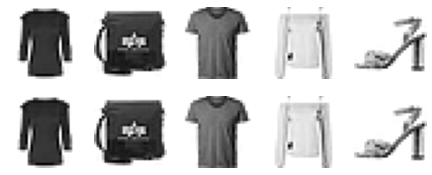

In [ ]:
import matplotlib.pyplot as plt

def plot_image(image):
    plt.imshow(image, cmap='binary')
    plt.axis('off')

def show_reconstructions(model, images=X_valid, n_images=5):
    # 재구성된 이미지 데이터
    recounstructions = model.predict(images[:n_images])
    flg = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1+image_index)
        plot_image(images[image_index])
        
        plt.subplot(2, n_images, 1+n_images + image_index)
        plot_image(images[image_index])
        
show_reconstructions(autoencoder)

- 차원 축소의 결과를 출력할 때 auto encoder를 이용하면 훨씬 보기 좋은 형태를 만들 수 있습니다.
- auto encoder가 분류모델을 잘 설명할 수 있으므로 PCA를 할 때 이용해보면 됩니다. 